# Biomedical Imaging 4C16/5C16 Project

## Tumor Segmentation & Classification

#### About the dataset

You have been given a dataset of ultrasound scans and segmentation maps associated with these ultrasound scans. These scans are to be used for training networks for ***breast cancer tumor segmentation and classification***.

The dataset has already been prepared to numpy files and is in the 'dataset' directory and is of the following structure:

- *dataset/*
    - *benign/*
        - *input.npy*
        - *target.npy*
    - *malignant/*
        - *input.npy*
        - *target.npy*
    - *normal/*
        - *input.npy*
        - *target.npy*

The *input.npy* and *output.npy* files are the input ultrasound scans and target segmentation maps for that tumor category (benign, malignant, normal).

- All input ultrasound scans are images of size 128x128x3. This means the height and width of these images are 128 and it is stored in RGB space. The pixels range from 0-1.
- All segmentation maps are images of size 128x128x1. This is an image where a value of 1 means that a tumor is detected at that location, and 0 means there is no tumor present.

The code block below displays examples of ultrasound scans and tumor segmentation maps for these image pairs.



---


## Notes on GPU instances usage for your mini-projects

_GPU instances_

Depending on your network architecture and size, training can take easily half an hour or more. This is normal. This means that this lab will take you a lot longer to complete than the previous labs.

Training will have to be done on a GPU instance. To change to GPU mode in your notebook, you need to go in the colab menu to `Runtime>Change runtime type` then select `hardware accelerator` to `GPU`.

This will restart your instance (obviously), so everytime you do this you'll need to start your again from the start of the notebook.

_GPU Usage Colab_

Google will limit your colab access if you overuse the GPU buy more than 3 hours per session. the cooldown time between session is dynamic, hence it could a day between sessions.

So, use GPU instances AS SPARINGLY AS POSSIBLE and ONLY FOR TRAINING. Use CPU instances for coding and tinkering.

Pace your efforts. Don't try to cram all your work at the last minute.  

---


In [2]:
# IMPORTANT
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/4c16-labs/code/lab-06/

Mounted at /content/gdrive
/content/gdrive/MyDrive/4c16-labs/code/lab-06


In [4]:
# Function to save a model
def save_model_to_disk(model, filename_base):
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open(filename_base + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{filename_base}.h5")
    print("Saved model to model.json and weights to model.h5")

In [5]:
# Download the dataset
!curl --create-dirs -o /home/tcd/data/medicalimaging-dataset.zip https://tcddeeplearning.blob.core.windows.net/deeplearning202324/medicalimaging-dataset.zip

!mkdir -p /home/tcd/data/medicalimaging/
!unzip -o /home/tcd/data/medicalimaging-dataset.zip -d /home/tcd/data/medicalimaging/

# Dataset is located in /home/tcd/data/medicalimaging/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16.1M  100 16.1M    0     0  4056k      0  0:00:04  0:00:04 --:--:-- 4057k
Archive:  /home/tcd/data/medicalimaging-dataset.zip
  inflating: /home/tcd/data/medicalimaging/dataset/normal/input.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/malignant/input.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/benign/target.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/benign/input.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/malignant/target.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/normal/target.npy  


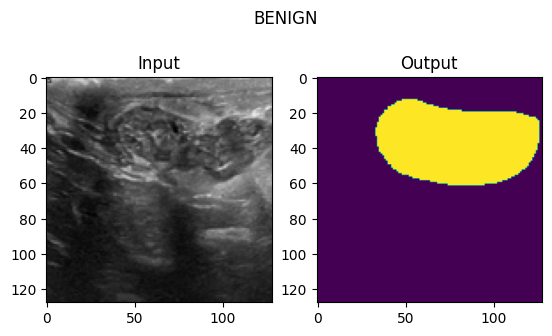

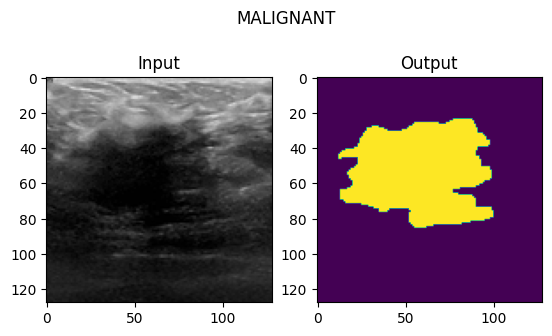

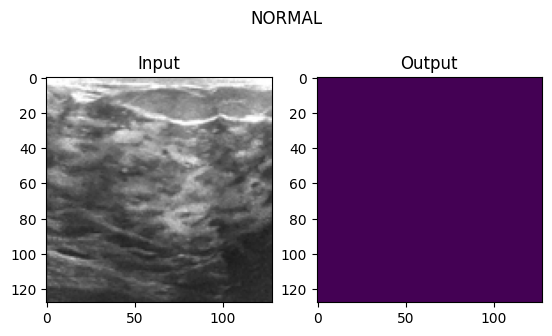

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random

for _type in ['benign', 'malignant', 'normal']:
    X = np.load(f'/home/tcd/data/medicalimaging/dataset/{_type}/input.npy')
    y = np.load(f'/home/tcd/data/medicalimaging/dataset/{_type}/target.npy')
    randomExample = random.randint(0, X.shape[0] - 1)
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(X[randomExample])
    axs[0].title.set_text('Input')
    axs[1].imshow(y[randomExample])
    axs[1].title.set_text('Output')
    fig.suptitle(_type.upper())
    plt.subplots_adjust(top=1.1)
    plt.show()

In [ ]:
from tensorflow import keras
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import random
import os
# Define some useful functions
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.i += 1

        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121)
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();


In [ ]:
data_dir = '/home/tcd/data/medicalimaging/dataset/'
labels = ['benign', 'malignant', 'normal']

images = []
labels_list = []

for label_index, label in enumerate(labels):
    train_images = np.load(os.path.join(data_dir, f'{label}/input.npy'))
    train_images = train_images / 255.0  # Normalize
    images.extend(train_images)
    labels_list.extend([label_index] * len(train_images))

images = np.array(images, dtype=np.float32)
labels = to_categorical(labels_list, num_classes=len(labels))

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1, random_state=42)

In [26]:
# --- Data augmentation ---

def augment_data(images, labels, augmentation_factor=5):
    augmented_images = []
    augmented_labels = []
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.3),
        layers.GaussianNoise(0.1),
        layers.RandomContrast(0.2)
    ])

    for image, label in zip(images, labels):
        for _ in range(augmentation_factor):
            augmented_image = data_augmentation(tf.expand_dims(image, 0))
            augmented_image = tf.squeeze(augmented_image)
            augmented_images.append(augmented_image.numpy())
            augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)

X_train_augmented, y_train_augmented = augment_data(X_train, y_train, augmentation_factor=9)
X_train_combined = np.concatenate([X_train, X_train_augmented])
y_train_combined = np.concatenate([y_train, y_train_augmented])

### The problem

You are required to train two separate neural networks for the purposes of:

1. **Classification Task**: Predicting whether an ultrasound is a) benign tumor,  b) contains a malignant tumor or c) normal (no-tumor).
    - Input are ultra sound scans (data from benign/malignant/normal), the output is a vector of the 3 probabilities for the classes (benign/malignant/normal) in that order (eg. [0.01, 0.99, 0] means the outcome is more likely to be malignant).
2. **Segmentation Task**: Predicting the segmentation map for a tumor of an input MRI scan if a tumor exists
    - Input are ultra sound scans (data from benign/malignant/normal), output is an image with the same height and width as the input image, but with only one channel and a value of 1 over the location where a tumor is present.

---

*IMPORTANT*

For Task 1, your model should be created with the name: 'classification_model',
the model size should be under 5M

For Task 2, your model should be created with the name: 'segmentation_model',
the model size should be under 3M.

In [9]:
# Hints:
#
# Load data into appropriate input/output formats.
# For example, for problem 1:
#   * inputs should be a collection of images of size [n_samples x height x width x 3],
#   * outputs should be of size [n_samples x height x width x 1].
#
# Load images using the `np.load` function. You can combine tensors using `np.concat`
# to form a single input or output dataset tensor. Look at previous labs for inspiration
# on what datasets look like.

#
# The amount of training data is very low, so usage of data
# augmentation techniques is strongly advised.(eg. see tf.keras.layers.RandomRotation)
#
# Classification Task hint: you may also think of using pre-trained networks
# with fine-tuning.
# Keep the model size under the restriction of 5Million parameters, you should
# be able to hit the target at much less model size. (Lower the better:))
#
# Segmentation Task hint: You might want to use transpose convolution layers to go up in tensor size.
# Popular segmentation architectures include U-Net (with skip-connections) or DnCNN.
# Keep the model size under the restriction of 3 Million parameters, you should
# be able to hit the target at very much lower model size. (Lower the better:))

In [31]:
classification_model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    #Convolutional layers
    layers.Conv2D(32, (4, 4), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(256, (4, 4), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax')
    ])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate=1e-3,
decay_steps=100000,
decay_rate=0.96,
staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
classification_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
classification_model.summary()

if (classification_model.count_params()  < 5000000) :
  save_model_to_disk(classification_model, "classification_model")
else:
  print("Your model is unecessarily complex, scale down!")

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 128, 128, 32)      1568      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_19 (Ba  (None, 64, 64, 32)        128       
 tchNormalization)                                               
                                                                 
 dropout_24 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 32, 32, 64)       

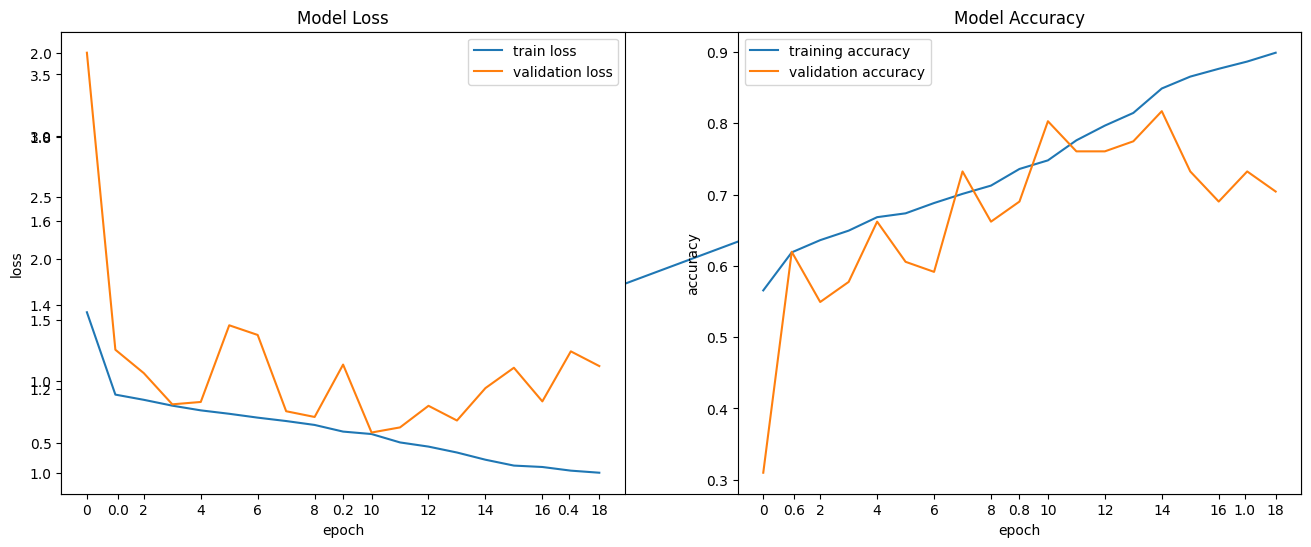

394/394 [==============================] - 9s 23ms/step - loss: 0.2551 - accuracy: 0.8989 - val_loss: 1.1240 - val_accuracy: 0.7042
Epoch 20/50
358/394 [==========================>...] - ETA: 0s - loss: 0.2390 - accuracy: 0.9033

In [ ]:
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
pltCallBack = PlotLossAccuracy()
history_classification = classification_model.fit(
    X_train_combined,
    y_train_combined,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[pltCallBack],
)

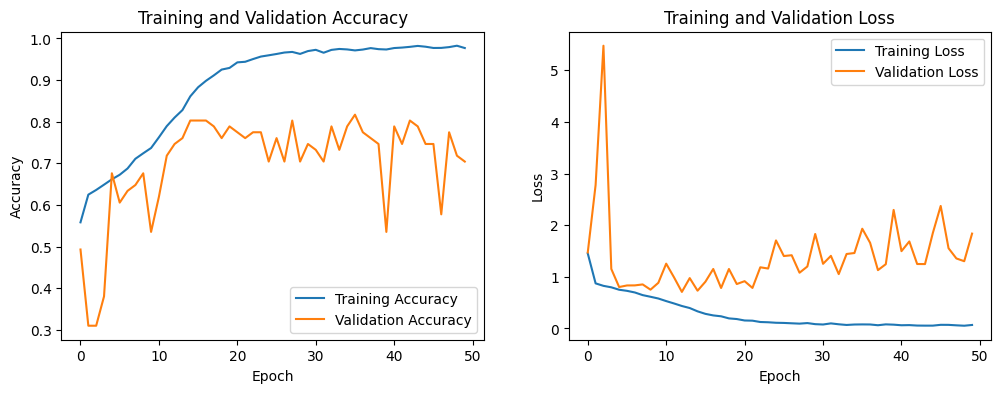

In [16]:
def plot_model_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')


    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

plot_model_history(history_classification)

In [ ]:
segmentation_model = ...

if (segmentation_model.count_params()  < 3000000) :
  save_model_to_disk(segmentation_model, "segmentation_model")
else:
  print("Your model is unecessarily complex, scale down!")